<a href="https://colab.research.google.com/github/sominshim/Predicting_Personality_through_Text/blob/Ujin/personality_predict_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np

import tensorflow as tf

!pip install -q tensorflow-hub
!pip install -q tfds-nightly
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("버전: ", tf.__version__)
print("즉시 실행 모드: ", tf.executing_eagerly())
print("허브 버전: ", hub.__version__)
print("GPU", "사용 가능" if tf.config.experimental.list_physical_devices("GPU") else "사용 불가능")

     |████████████████████████████████| 3.7MB 14.2MB/s 
버전:  2.3.0
즉시 실행 모드:  True
허브 버전:  0.10.0
GPU 사용 가능


In [3]:
np.random.seed(42)

In [4]:
#드라이브에 접근할 수 있도록 아래 코드 입력
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#불러올 파일의 경로를 filename 변수에 저장
filename = '/content/drive/My Drive/mbti_1.csv'

In [6]:
#pandas read_csv로 불러오기
import pandas as pd
data = pd.read_csv(filename)
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [7]:
[p.split('|||') for p in data.head(1).posts.values]

[["'http://www.youtube.com/watch?v=qsXHcwe3krw",
  'http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg',
  'enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks',
  'What has been the most life-changing experience in your life?',
  'http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.',
  'May the PerC Experience immerse you.',
  'The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206',
  "Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...",
  '84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


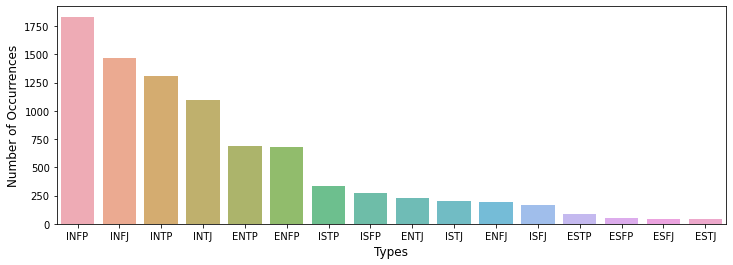

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

cnt_srs = data['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

## 4개의 클래스로 분류

In [9]:
# Split mbti personality into 4 letters and binarize
titles = ["Extraversion (E) - Introversion (I)",
          "Sensation (S) - INtuition (N)",
          "Thinking (T) - Feeling (F)",
          "Judgement (J) - Perception (P)"
         ] 
b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]


#transform mbti to binary vector
def translate_personality(personality):
    return [b_Pers[l] for l in personality]

#transform binary vector to mbti personality
def translate_back(personality):
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

list_personality_bin = np.array([translate_personality(p) for p in data.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)


Binarize MBTI list: 
[[0 0 0 0]
 [1 0 1 1]
 [0 0 1 1]
 ...
 [0 0 1 1]
 [0 0 0 1]
 [0 0 0 1]]


In [10]:
data['I-E'] = list_personality_bin[:,0]
data['N-S'] = list_personality_bin[:,1]
data['F-T'] = list_personality_bin[:,2]
data['J-P'] = list_personality_bin[:,3]

In [11]:
data.head()

,type,posts,I-E,N-S,F-T,J-P
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,0
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,1
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,0
4,ENTJ,'You're fired.|||That's another silly misconce...,1,0,1,0


## post 전처리

In [12]:
data['posts'].head()

0    'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1    'I'm finding the lack of me in these posts ver...
2    'Good one  _____   https://www.youtube.com/wat...
3    'Dear INTP,   I enjoyed our conversation the o...
4    'You're fired.|||That's another silly misconce...
Name: posts, dtype: object

In [13]:
import re
import string

def cleaner(post):
    # 소문자 변환
    post = post.lower() 
    
    # '|||' 제거
    post = post.replace('|||', "") 

    # URL, 링크 등 특수문자 제거
    post = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', '', post, flags=re.MULTILINE) 

    # 구두점 제거
    post = post.translate(str.maketrans('', '', string.punctuation))

    # 공백 제거
    post=re.sub( '\s+', ' ', post ).strip()

     # MBTI 제거
    post = re.sub('infj|entp|intp|intj|entj|enfj|infp|enfp|isfp|istp|isfj|istj|estp|esfp|estj|esfj',"", post)


    return post

In [14]:
posts = data.posts.tolist()
posts = [cleaner(post) for post in posts]

In [15]:
# 단어 개수 계산
from collections import Counter

word_count=Counter()
for post in posts:
    word_count.update(post.split(" "))

In [16]:
print(len(word_count))
print(len(posts[0]))

319913
3046


In [17]:
data['clean_posts'] = posts
data.head()

,type,posts,I-E,N-S,F-T,J-P,clean_posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,0,and moments sportscenter not top ten plays pr...
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,1,im finding the lack of me in these posts very ...
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,1,good one course to which i say i know thats my...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,0,dear i enjoyed our conversation the other day...
4,ENTJ,'You're fired.|||That's another silly misconce...,1,0,1,0,youre firedthats another silly misconception t...


## train, test set 나누기

비율같게

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data[['type']]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]

#### train set

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


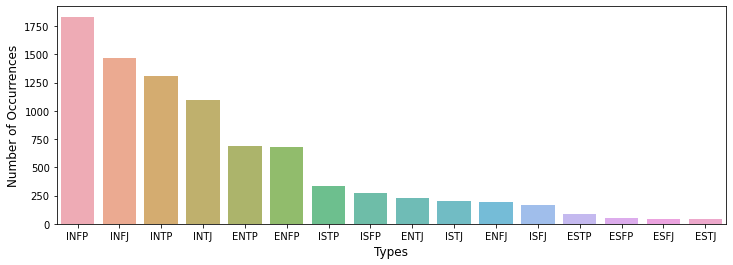

In [19]:
cnt_train = strat_train_set['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_train.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

### test set

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


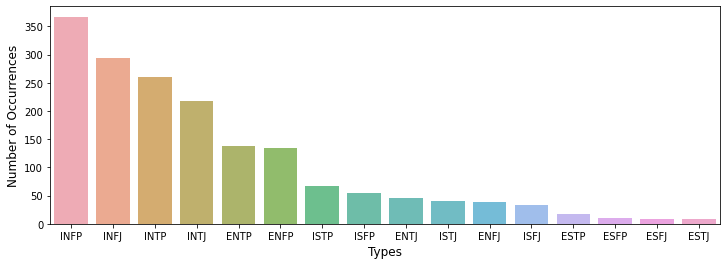

In [20]:
cnt_test = strat_test_set['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_test.index, cnt_test.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

# 모델1

### 임베딩

In [34]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

In [35]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(4)) #4개의 클래스 분류

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 20)                400020    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                336       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
Total params: 400,424
Trainable params: 400,424
Non-trainable params: 0
_________________________________________________________________


손실함수와 옵티마이저

In [36]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### train set : train, val set으로 나누기

비율 같게

In [37]:
strat_train_set = strat_train_set.reset_index(drop=True)

In [38]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(strat_train_set, strat_train_set[['type']]):
    train = strat_train_set.loc[train_index]
    val = strat_train_set.loc[test_index]

In [39]:
x_val = val['clean_posts']
partial_x_train = train['clean_posts']

y_val = np.array([translate_personality(p) for p in val.type])
partial_y_train = np.array([translate_personality(p) for p in train.type])

##### 레이블 벡터 변환
test_labels = np.array([translate_personality(p) for p in strat_test_set.type])
test_posts = strat_test_set['clean_posts']

In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=20,
                    validation_data=(x_val, y_val))

Epoch 1/20
278/278 [==============================] - 3s 11ms/step - loss: 10.4347 - accuracy: 0.2109 - val_loss: 10.8693 - val_accuracy: 0.2111
Epoch 2/20
278/278 [==============================] - 3s 10ms/step - loss: 6.9000 - accuracy: 0.2693 - val_loss: 3.7276 - val_accuracy: 0.3249
Epoch 3/20
278/278 [==============================] - 3s 10ms/step - loss: 4.1371 - accuracy: 0.3246 - val_loss: 4.3663 - val_accuracy: 0.3192
Epoch 4/20
278/278 [==============================] - 3s 10ms/step - loss: 4.7264 - accuracy: 0.3238 - val_loss: 5.2372 - val_accuracy: 0.3177
Epoch 5/20
278/278 [==============================] - 3s 11ms/step - loss: 5.7424 - accuracy: 0.3154 - val_loss: 6.1082 - val_accuracy: 0.3062
Epoch 6/20
278/278 [==============================] - 3s 10ms/step - loss: 6.5930 - accuracy: 0.3123 - val_loss: 6.6656 - val_accuracy: 0.2990
Epoch 7/20
278/278 [==============================] - 3s 10ms/step - loss: 7.4146 - accuracy: 0.3096 - val_loss: 7.3623 - val_accuracy: 0.29

#### - loss, accuracy graph

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

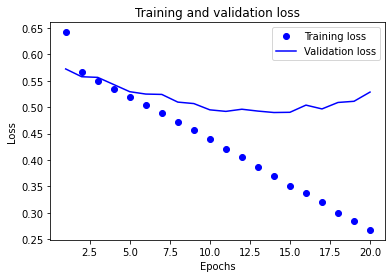

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

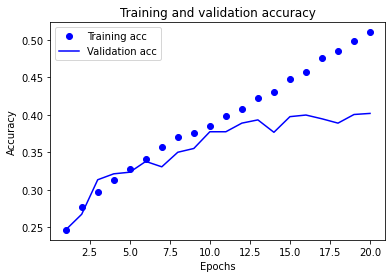

In [ ]:
plt.clf() #그래프를 초기화합니다.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
results = model.evaluate(test_posts, test_labels)
results

55/55 [==============================] - 0s 9ms/step - loss: 7.3504 - accuracy: 0.2980


[7.350424766540527, 0.29798272252082825]

## 모델2 

loss = Binary Crossentropy

In [49]:
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
model2 = tf.keras.Sequential()
model2.add(hub_layer)
model2.add(tf.keras.layers.Dense(16, activation='relu'))
model2.add(tf.keras.layers.Dense(4)) #4개의 클래스 분류

model2.summary()

model2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 20)                400020    
_________________________________________________________________
dense_6 (Dense)              (None, 16)                336       
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 68        
Total params: 400,424
Trainable params: 400,424
Non-trainable params: 0
_________________________________________________________________


In [50]:
history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=20,
                    validation_data=(x_val, y_val))

Epoch 1/20
278/278 [==============================] - 4s 13ms/step - loss: 0.7650 - accuracy: 0.2239 - val_loss: 0.5847 - val_accuracy: 0.2464
Epoch 2/20
278/278 [==============================] - 4s 13ms/step - loss: 0.5705 - accuracy: 0.2871 - val_loss: 0.5634 - val_accuracy: 0.2752
Epoch 3/20
278/278 [==============================] - 4s 13ms/step - loss: 0.5481 - accuracy: 0.3129 - val_loss: 0.5468 - val_accuracy: 0.3012
Epoch 4/20
278/278 [==============================] - 4s 13ms/step - loss: 0.5303 - accuracy: 0.3309 - val_loss: 0.5329 - val_accuracy: 0.3213
Epoch 5/20
278/278 [==============================] - 4s 13ms/step - loss: 0.5165 - accuracy: 0.3435 - val_loss: 0.5301 - val_accuracy: 0.3242
Epoch 6/20
278/278 [==============================] - 4s 13ms/step - loss: 0.5001 - accuracy: 0.3534 - val_loss: 0.5178 - val_accuracy: 0.3163
Epoch 7/20
278/278 [==============================] - 4s 13ms/step - loss: 0.4862 - accuracy: 0.3703 - val_loss: 0.5173 - val_accuracy: 0.3782

#### - loss, accuracy graph

In [51]:
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

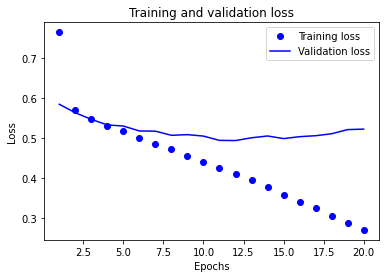

In [52]:
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss2, 'bo', label='Training loss')
plt.plot(epochs, val_loss2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

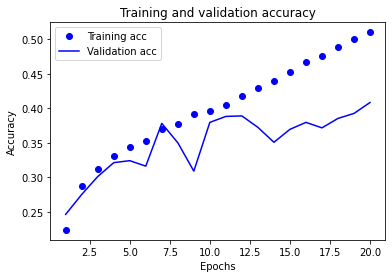

In [53]:
plt.clf() #그래프를 초기화합니다.

plt.plot(epochs, acc2, 'bo', label='Training acc')
plt.plot(epochs, val_acc2, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [54]:
results = model2.evaluate(test_posts, test_labels)
results

55/55 [==============================] - 1s 11ms/step - loss: 0.5336 - accuracy: 0.4121


[0.5336045622825623, 0.4121037423610687]